In [1]:
import datetime
import pandas as pd
import pandas_datareader.data as web

In [2]:
start = datetime.datetime(2012, 5, 18) # or start = '1/1/2016'
end = datetime.date.today()
df = web.DataReader('FB', 'yahoo', start, end)
print (df.head())  # print first rows of the prices data

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-05-18  42.049999  45.000000  38.000000  38.230000  38.230000  573576400
2012-05-21  36.529999  36.660000  33.000000  34.029999  34.029999  168192700
2012-05-22  32.610001  33.590000  30.940001  31.000000  31.000000  101786600
2012-05-23  31.370001  32.500000  31.360001  32.000000  32.000000   73600000
2012-05-24  32.950001  33.209999  31.770000  33.029999  33.029999   50237200


In [3]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.preprocessing as prep
from keras import backend

Using TensorFlow backend.


In [ ]:
#import os
#s=os.getcwd()
#s

In [ ]:
#df = pd.read_csv('/Users/Yuffie/USA/SCU/COEN281DataMining/TermProject/data/GOOG.csv')
#df.head()

In [4]:
# Data preparation
col_list = df.columns.tolist()
col_list

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [6]:
col_list.remove('Close')
col_list.append('Close')
#col_list.remove('Date')
col_list.remove('Volume')
col_list

['Open', 'High', 'Low', 'Adj Close', 'Close']

In [7]:
df = df[col_list]
df.head()

,Open,High,Low,Adj Close,Close
Date,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999


In [8]:
# Save data
df.to_csv('FB-adjust.csv', index=False)
validate_df = pd.read_csv('FB-adjust.csv')
validate_df.head()

,Open,High,Low,Adj Close,Close
0,42.049999,45.000000,38.000000,38.230000,38.230000
1,36.529999,36.660000,33.000000,34.029999,34.029999
2,32.610001,33.590000,30.940001,31.000000,31.000000
3,31.370001,32.500000,31.360001,32.000000,32.000000
4,32.950001,33.209999,31.770000,33.029999,33.029999


In [9]:
# Standardization the dataset
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test


In [10]:
# Split the data to X_train, y_train, X_test, y_test
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    y_test_org = result[int(row) :, -1][ : ,-1]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test, y_test_org]

In [11]:
# Build LSTM Neural Network
# LSTM --> Dropout --> LSTM --> Dropout --> Fully-Conneted(Dense)
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        return_sequences=True,
        input_shape=(None, 5), units=20))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        units=1))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [12]:
window = 20
X_train, y_train, X_test, y_test, y_test_org = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1238, 20, 5)
y_train (1238,)
X_test (137, 20, 5)
y_test (137,)


In [13]:
model = build_model([X_train.shape[2], window, 100, 1])

Compilation Time :  0.022166967391967773


In [14]:
# Training the model
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=300,
    validation_split=0.1,
    verbose=0)

In [15]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
print(model.metrics_names)
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.01 MSE (0.11 RMSE)
['loss', 'acc']
Test Score: 0.02 MSE (0.15 RMSE)


In [16]:
#Visualize the Prediction
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))
print('error_ratio', ratio)
#print('error_abs', diff)
#print(pred)

error_ratio [-0.098042958775797606, -0.094387898152137217, -0.088177836205370785, -0.1016463994996889, -0.091531150874285205, -0.077665662356397824, -0.075558213633958315, -0.074090689005970711, -0.048003458927490361, -0.05535843483722569, -0.041504548351936177, -0.043161685013260009, -0.056630789900777967, -0.040992185984557117, -0.048125189397700052, -0.017690875810006501, -0.026214407917106608, -0.020459438781791683, -0.03715887691878339, -0.048873779787159122, -0.062470022008482062, -0.066564632619159458, -0.067597965841832863, -0.06932430389704114, -0.068893295978076807, -0.080800825611690885, -0.089356994003521706, -0.097671302640438995, -0.045262016884400125, -0.041384407926094657, -0.038249635124750658, -0.040201666241083678, -0.054790438263231045, -0.051445192951791729, -0.053749324562053502, -0.055228623280366262, -0.059511721066375811, -0.059027507873875229, -0.067678306476899763, -0.070482866664272725, -0.077388068925051789, -0.090928014565120785, -0.088251372855242982, -0.

In [19]:
# Scale the representation back
y_test = y_test_org
pred_org = []
for u in range(len(y_test)):
    pred_org.append(y_test[u]/(ratio[u] + 1))
    #print(ratio[u])
print(pred_org)
print(y_test)

[30.722082908061733, 30.322031854443029, 29.654906486886244, 31.168127989253051, 30.07257764126091, 28.579659158462047, 28.287340950688758, 28.015703797331483, 25.210175630430172, 25.745214795634514, 24.100270857082542, 23.953890266525992, 24.974314136796977, 23.117642709471184, 23.490485041674422, 20.217669276335435, 20.610286456458009, 19.611233838146969, 20.761473020626084, 21.521853319761565, 22.58061128386823, 22.765368382843828, 22.7155231585511, 22.789892428493779, 22.671946092553274, 23.868603901434323, 24.773702594150539, 25.744498726436142, 20.42445188612438, 20.154064006201253, 19.755646261142338, 19.774987445193279, 21.032371872615876, 20.536504433117031, 20.628783161465851, 20.661083179484034, 20.999730078926241, 20.872022470735011, 21.698519020354382, 21.9468789421785, 22.663916751691541, 24.145503713327635, 23.943002873898575, 24.536626622399059, 24.078047251006939, 23.551078744699851, 21.6317954279567, 22.030048622464371, 21.563017821336327, 22.272324934391573, 25.24465

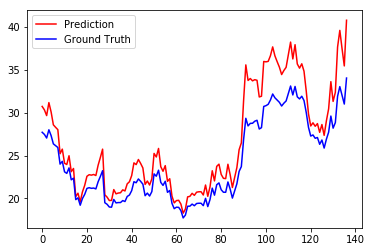

In [18]:
import matplotlib.pyplot as plt2

plt2.plot(pred_org, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()